#### How to use Boosting

`https://keeryang.github.io/papers/Profits_2021Aug28.pdf`

In [1]:
import optuna
from lightgbm import plot_importance, LGBMRegressor
import getFamaFrenchFactors as gff
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

/Users/daniel/Desktop/Projects/DS/cc/Fama-French-models/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
stocks_df = pd.read_csv('../data/market_data/sp500/sp500_stocks.csv')
df = stocks_df.pivot(
    index='Date', columns='Symbol', values='Adj Close')

df = df.reset_index()
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

df.head()

Symbol,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,20.122227,4.496877,6.470741,NaN,NaN,18.952162,7.994444,32.212460,37.090000,23.694084,...,52.883579,9.905468,41.963718,12.918809,43.185623,NaN,19.158102,52.587051,28.670000,NaN
2010-01-05,19.903643,5.005957,6.481929,NaN,NaN,18.799042,7.967778,32.411549,37.700001,23.656675,...,52.765053,10.115747,44.515926,12.765595,43.354244,NaN,19.092571,54.251759,28.620001,NaN
2010-01-06,19.832930,4.798554,6.378825,NaN,NaN,18.903446,7.933333,32.756096,37.619999,23.611784,...,53.614498,10.003899,43.932011,12.790110,43.728970,NaN,18.956089,54.234219,28.400000,NaN
2010-01-07,19.807215,4.939964,6.367033,NaN,NaN,19.060045,7.886667,32.725471,36.889999,23.424749,...,53.456463,9.959157,44.870213,12.734954,43.591564,NaN,18.950626,55.478374,27.690001,NaN
2010-01-08,19.800785,4.845691,6.409364,NaN,NaN,19.157482,7.871111,32.595306,36.689999,23.559416,...,53.397202,9.867439,44.548744,12.741086,43.416687,NaN,18.956089,54.313072,27.600000,NaN


In [4]:
tickers = ['AAPL']

In [5]:
ff5 = pd.DataFrame(gff.famaFrench5Factor(frequency='m'))
ff5.head()

,date_ff_factors,Mkt-RF,SMB,HML,RMW,CMA,RF
0,1963-07-31,-0.0039,-0.0041,-0.0097,0.0068,-0.0118,0.0027
1,1963-08-31,0.0507,-0.0080,0.0180,0.0036,-0.0035,0.0025
2,1963-09-30,-0.0157,-0.0052,0.0013,-0.0071,0.0029,0.0027
3,1963-10-31,0.0253,-0.0139,-0.0010,0.0280,-0.0201,0.0029
4,1963-11-30,-0.0085,-0.0088,0.0175,-0.0051,0.0224,0.0027


In [6]:
fff = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

N_lags = 10

for f in fff:
  for i in range(1, N_lags):
    ff5[f'{f}_{i}L'] = ff5[f].shift(-i)
    

In [7]:
mon = pd.DataFrame(df[tickers[0]]).resample('ME').last()
mon_rets = mon.pct_change().dropna()

In [8]:
import numpy as np

# Пример преобразования с использованием логарифма
log_transformed_features = np.log1p(
    ff5[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']])

log_transformed_features

,Mkt-RF,SMB,HML,RMW,CMA,RF
0,-0.003908,-0.004108,-0.009747,0.006777,-0.011870,0.002696
1,0.049457,-0.008032,0.017840,0.003594,-0.003506,0.002497
2,-0.015825,-0.005214,0.001299,-0.007125,0.002896,0.002696
3,0.024985,-0.013998,-0.001001,0.027615,-0.020305,0.002896
4,-0.008536,-0.008839,0.017349,-0.005113,0.022153,0.002696
...,...,...,...,...,...,...
724,0.084709,-0.001201,0.016267,-0.039885,-0.010050,0.004390
725,0.047551,0.070645,0.048123,-0.031181,0.013114,0.004291
726,0.007075,-0.059113,-0.024088,0.006876,-0.009646,0.004689
727,0.049361,-0.007831,-0.035524,-0.020101,-0.021632,0.004191


In [9]:
sqrt_transformed_features = np.sqrt(
    np.abs(ff5[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']]))
sqrt_transformed_features

,Mkt-RF,SMB,HML,RMW,CMA,RF
0,0.062450,0.064031,0.098489,0.082462,0.108628,0.051962
1,0.225167,0.089443,0.134164,0.060000,0.059161,0.050000
2,0.125300,0.072111,0.036056,0.084261,0.053852,0.051962
3,0.159060,0.117898,0.031623,0.167332,0.141774,0.053852
4,0.092195,0.093808,0.132288,0.071414,0.149666,0.051962
...,...,...,...,...,...,...
724,0.297321,0.034641,0.128062,0.197737,0.100000,0.066332
725,0.220681,0.270555,0.222036,0.175214,0.114891,0.065574
726,0.084261,0.239583,0.154272,0.083066,0.097980,0.068557
727,0.224944,0.088318,0.186815,0.141067,0.146287,0.064807


In [10]:
mixed_transformed_feature = np.sqrt(np.abs(np.log1p(ff5['Mkt-RF'] + ff5['SMB'])))
mixed_transformed_feature

0      0.089622
1      0.204484
2      0.145332
3      0.106468
4      0.132104
         ...   
724    0.289146
725    0.339151
726    0.227176
727    0.204718
728    0.128694
Length: 729, dtype: float64

In [11]:
squared_features = ff5[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']]**2
cubed_features = ff5[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']]**3

In [12]:
Mkt_RF_SMA = ff5['Mkt-RF'].rolling(window=3).mean()
Mkt_RF_SMA

0           NaN
1           NaN
2      0.010367
3      0.020100
4      0.000367
         ...   
724    0.001367
725    0.035067
726    0.048067
727    0.035467
728    0.028667
Name: Mkt-RF, Length: 729, dtype: float64

## Обучение бустинга

In [13]:
ff5

,date_ff_factors,Mkt-RF,SMB,HML,RMW,CMA,RF,Mkt-RF_1L,Mkt-RF_2L,Mkt-RF_3L,...,RMW_9L,CMA_1L,CMA_2L,CMA_3L,CMA_4L,CMA_5L,CMA_6L,CMA_7L,CMA_8L,CMA_9L
0,1963-07-31,-0.0039,-0.0041,-0.0097,0.0068,-0.0118,0.0027,0.0507,-0.0157,0.0253,...,-0.0127,-0.0035,0.0029,-0.0201,0.0224,-0.0007,0.0147,0.0091,0.0322,-0.0108
1,1963-08-31,0.0507,-0.0080,0.0180,0.0036,-0.0035,0.0025,-0.0157,0.0253,-0.0085,...,-0.0016,0.0029,-0.0201,0.0224,-0.0007,0.0147,0.0091,0.0322,-0.0108,0.0017
2,1963-09-30,-0.0157,-0.0052,0.0013,-0.0071,0.0029,0.0027,0.0253,-0.0085,0.0183,...,-0.0028,-0.0201,0.0224,-0.0007,0.0147,0.0091,0.0322,-0.0108,0.0017,-0.0017
3,1963-10-31,0.0253,-0.0139,-0.0010,0.0280,-0.0201,0.0029,-0.0085,0.0183,0.0224,...,0.0008,0.0224,-0.0007,0.0147,0.0091,0.0322,-0.0108,0.0017,-0.0017,0.0191
4,1963-11-30,-0.0085,-0.0088,0.0175,-0.0051,0.0224,0.0027,0.0183,0.0224,0.0154,...,0.0012,-0.0007,0.0147,0.0091,0.0322,-0.0108,0.0017,-0.0017,0.0191,0.0035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724,2023-11-30,0.0884,-0.0012,0.0164,-0.0391,-0.0100,0.0044,0.0487,0.0071,0.0506,...,NaN,0.0132,-0.0096,-0.0214,0.0118,NaN,NaN,NaN,NaN,NaN
725,2023-12-31,0.0487,0.0732,0.0493,-0.0307,0.0132,0.0043,0.0071,0.0506,0.0283,...,NaN,-0.0096,-0.0214,0.0118,NaN,NaN,NaN,NaN,NaN,NaN
726,2024-01-31,0.0071,-0.0574,-0.0238,0.0069,-0.0096,0.0047,0.0506,0.0283,NaN,...,NaN,-0.0214,0.0118,NaN,NaN,NaN,NaN,NaN,NaN,NaN
727,2024-02-29,0.0506,-0.0078,-0.0349,-0.0199,-0.0214,0.0042,0.0283,NaN,NaN,...,NaN,0.0118,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
factors = ff5.rename(columns={'date_ff_factors': 'Date'})
factors_0 = pd.merge(mon_rets, factors, on='Date', how='left')
factors_0 = factors_0.dropna()

Y = (factors_0[tickers[0]] - factors_0['RF'])
X = factors_0.drop(
    columns=['RF', tickers[0]]).set_index('Date')

# 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA'

In [15]:
X

,Mkt-RF,SMB,HML,RMW,CMA,Mkt-RF_1L,Mkt-RF_2L,Mkt-RF_3L,Mkt-RF_4L,Mkt-RF_5L,...,RMW_9L,CMA_1L,CMA_2L,CMA_3L,CMA_4L,CMA_5L,CMA_6L,CMA_7L,CMA_8L,CMA_9L
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-28,0.0340,0.0151,0.0323,-0.0027,0.0143,0.0631,0.0200,-0.0789,-0.0557,0.0693,...,0.0045,0.0169,0.0172,-0.0021,-0.0155,0.0201,-0.0159,0.0038,-0.0026,0.0159
2010-03-31,0.0631,0.0185,0.0221,-0.0065,0.0169,0.0200,-0.0789,-0.0557,0.0693,-0.0477,...,-0.0344,0.0172,-0.0021,-0.0155,0.0201,-0.0159,0.0038,-0.0026,0.0159,0.0316
2010-04-30,0.0200,0.0498,0.0289,0.0069,0.0172,-0.0789,-0.0557,0.0693,-0.0477,0.0954,...,-0.0076,-0.0021,-0.0155,0.0201,-0.0159,0.0038,-0.0026,0.0159,0.0316,0.0083
2010-05-31,-0.0789,0.0004,-0.0244,0.0130,-0.0021,-0.0557,0.0693,-0.0477,0.0954,0.0388,...,-0.0194,-0.0155,0.0201,-0.0159,0.0038,-0.0026,0.0159,0.0316,0.0083,0.0088
2010-06-30,-0.0557,-0.0247,-0.0470,-0.0016,-0.0155,0.0693,-0.0477,0.0954,0.0388,0.0060,...,0.0176,0.0201,-0.0159,0.0038,-0.0026,0.0159,0.0316,0.0083,0.0088,-0.0003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-28,-0.0258,0.0066,-0.0081,0.0101,-0.0133,0.0251,0.0061,0.0035,0.0646,0.0321,...,-0.0391,-0.0237,0.0286,-0.0722,-0.0162,0.0057,-0.0237,-0.0083,-0.0065,-0.0100
2023-03-31,0.0251,-0.0694,-0.0885,0.0224,-0.0237,0.0061,0.0035,0.0646,0.0321,-0.0239,...,-0.0307,0.0286,-0.0722,-0.0162,0.0057,-0.0237,-0.0083,-0.0065,-0.0100,0.0132
2023-04-30,0.0061,-0.0256,-0.0004,0.0242,0.0286,0.0035,0.0646,0.0321,-0.0239,-0.0524,...,0.0069,-0.0722,-0.0162,0.0057,-0.0237,-0.0083,-0.0065,-0.0100,0.0132,-0.0096


In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, shuffle=False)

In [17]:
X_train.head()

,Mkt-RF,SMB,HML,RMW,CMA,Mkt-RF_1L,Mkt-RF_2L,Mkt-RF_3L,Mkt-RF_4L,Mkt-RF_5L,...,RMW_9L,CMA_1L,CMA_2L,CMA_3L,CMA_4L,CMA_5L,CMA_6L,CMA_7L,CMA_8L,CMA_9L
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-28,0.0340,0.0151,0.0323,-0.0027,0.0143,0.0631,0.0200,-0.0789,-0.0557,0.0693,...,0.0045,0.0169,0.0172,-0.0021,-0.0155,0.0201,-0.0159,0.0038,-0.0026,0.0159
2010-03-31,0.0631,0.0185,0.0221,-0.0065,0.0169,0.0200,-0.0789,-0.0557,0.0693,-0.0477,...,-0.0344,0.0172,-0.0021,-0.0155,0.0201,-0.0159,0.0038,-0.0026,0.0159,0.0316
2010-04-30,0.0200,0.0498,0.0289,0.0069,0.0172,-0.0789,-0.0557,0.0693,-0.0477,0.0954,...,-0.0076,-0.0021,-0.0155,0.0201,-0.0159,0.0038,-0.0026,0.0159,0.0316,0.0083
2010-05-31,-0.0789,0.0004,-0.0244,0.0130,-0.0021,-0.0557,0.0693,-0.0477,0.0954,0.0388,...,-0.0194,-0.0155,0.0201,-0.0159,0.0038,-0.0026,0.0159,0.0316,0.0083,0.0088
2010-06-30,-0.0557,-0.0247,-0.0470,-0.0016,-0.0155,0.0693,-0.0477,0.0954,0.0388,0.0060,...,0.0176,0.0201,-0.0159,0.0038,-0.0026,0.0159,0.0316,0.0083,0.0088,-0.0003


In [18]:
X.shape

(161, 50)

In [19]:
# selected_features = ['Mkt-RF', 'RMW', 'CMA']
# selected_features = ['CMA_8L', 'SMB_7L', 'CMA_6L']

selected_features = list(X.columns)
# selected_features.remove('date_ff_factors')
# selected_features.remove('RF')
                     
                  # 'HML_8L', 'HML_4L', 'RMW_9L', 'RMW_5L', 'SMB_1L']
                  
                  
# selected_features = ['SMB_5L',
#                      'HML_7L',
#                      'RMW_5L',
#                      'HML_2L',
#                      'CMA_9L',
#                      'HML_1L',
#                      'CMA_6L',
#                      'HML_4L',
#                      'CMA_8L',
#                      'RMW_6L',
#                      'SMB_6L',
#                     #  'RMW',
#                      'SMB_2L',
#                     #  'CMA',
#                     #  'Mkt-RF'
#                      ]


In [20]:
selected_features

['Mkt-RF',
 'SMB',
 'HML',
 'RMW',
 'CMA',
 'Mkt-RF_1L',
 'Mkt-RF_2L',
 'Mkt-RF_3L',
 'Mkt-RF_4L',
 'Mkt-RF_5L',
 'Mkt-RF_6L',
 'Mkt-RF_7L',
 'Mkt-RF_8L',
 'Mkt-RF_9L',
 'SMB_1L',
 'SMB_2L',
 'SMB_3L',
 'SMB_4L',
 'SMB_5L',
 'SMB_6L',
 'SMB_7L',
 'SMB_8L',
 'SMB_9L',
 'HML_1L',
 'HML_2L',
 'HML_3L',
 'HML_4L',
 'HML_5L',
 'HML_6L',
 'HML_7L',
 'HML_8L',
 'HML_9L',
 'RMW_1L',
 'RMW_2L',
 'RMW_3L',
 'RMW_4L',
 'RMW_5L',
 'RMW_6L',
 'RMW_7L',
 'RMW_8L',
 'RMW_9L',
 'CMA_1L',
 'CMA_2L',
 'CMA_3L',
 'CMA_4L',
 'CMA_5L',
 'CMA_6L',
 'CMA_7L',
 'CMA_8L',
 'CMA_9L']

In [21]:
X[selected_features].head()

,Mkt-RF,SMB,HML,RMW,CMA,Mkt-RF_1L,Mkt-RF_2L,Mkt-RF_3L,Mkt-RF_4L,Mkt-RF_5L,...,RMW_9L,CMA_1L,CMA_2L,CMA_3L,CMA_4L,CMA_5L,CMA_6L,CMA_7L,CMA_8L,CMA_9L
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-28,0.0340,0.0151,0.0323,-0.0027,0.0143,0.0631,0.0200,-0.0789,-0.0557,0.0693,...,0.0045,0.0169,0.0172,-0.0021,-0.0155,0.0201,-0.0159,0.0038,-0.0026,0.0159
2010-03-31,0.0631,0.0185,0.0221,-0.0065,0.0169,0.0200,-0.0789,-0.0557,0.0693,-0.0477,...,-0.0344,0.0172,-0.0021,-0.0155,0.0201,-0.0159,0.0038,-0.0026,0.0159,0.0316
2010-04-30,0.0200,0.0498,0.0289,0.0069,0.0172,-0.0789,-0.0557,0.0693,-0.0477,0.0954,...,-0.0076,-0.0021,-0.0155,0.0201,-0.0159,0.0038,-0.0026,0.0159,0.0316,0.0083
2010-05-31,-0.0789,0.0004,-0.0244,0.0130,-0.0021,-0.0557,0.0693,-0.0477,0.0954,0.0388,...,-0.0194,-0.0155,0.0201,-0.0159,0.0038,-0.0026,0.0159,0.0316,0.0083,0.0088
2010-06-30,-0.0557,-0.0247,-0.0470,-0.0016,-0.0155,0.0693,-0.0477,0.0954,0.0388,0.0060,...,0.0176,0.0201,-0.0159,0.0038,-0.0026,0.0159,0.0316,0.0083,0.0088,-0.0003


In [22]:
def objective(trial):

    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'n_estimators': trial.suggest_int('n_estimators', 10, 200),
        'max_depth': trial.suggest_int('max_depth', 1, 100),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.1, 1.0),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'lambda_l1': trial.suggest_float('lambda_l1', 0, 100),
        'lambda_l2': trial.suggest_float('lambda_l2', 0, 100),
        # 'importance_type': 'split',
        'importance_type': trial.suggest_categorical('importance_type', ['split', 'gain']),

        'n_jobs': 12,
        'random_state': 42
    }

    regr = LGBMRegressor(**params)
    regr.fit(X_train.loc[:, selected_features], y_train)
    preds = regr.predict(X_test.loc[:, selected_features])
    # mse = mean_squared_error(y_test, preds)
    # return mse
    return r2_score(y_test, preds)

In [23]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-05-13 19:29:15,668] A new study created in memory with name: no-name-2e1b5632-ad01-4729-b5e9-43654f31bae3
[I 2024-05-13 19:29:15,708] Trial 0 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.41872799568914165, 'num_leaves': 44, 'n_estimators': 107, 'max_depth': 53, 'min_data_in_leaf': 54, 'feature_fraction': 0.6830012488156512, 'subsample': 0.12076045419179639, 'lambda_l1': 96.92429737223854, 'lambda_l2': 61.79533767769866, 'importance_type': 'gain'}. Best is trial 0 with value: -0.00941605220776709.
[I 2024-05-13 19:29:15,742] Trial 1 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.030394132295901325, 'num_leaves': 70, 'n_estimators': 152, 'max_depth': 44, 'min_data_in_leaf': 55, 'feature_fraction': 0.9523491896941598, 'subsample': 0.6800300082049121, 'lambda_l1': 38.65243582685343, 'lambda_l2': 78.75376817019747, 'importance_type': 'gain'}. Best is trial 0 with value: -0.00941605220776709.
[I 2024-05-13 19:29:15,755] 

[LightGBM] [Warning] lambda_l1 is set=96.92429737223854, reg_alpha=0.0 will be ignored. Current value: lambda_l1=96.92429737223854
[LightGBM] [Warning] feature_fraction is set=0.6830012488156512, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6830012488156512
[LightGBM] [Warning] lambda_l2 is set=61.79533767769866, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.79533767769866
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] lambda_l1 is set=96.92429737223854, reg_alpha=0.0 will be ignored. Current value: lambda_l1=96.92429737223854
[LightGBM] [Warning] feature_fraction is set=0.6830012488156512, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6830012488156512
[LightGBM] [Warning] lambda_l2 is set=61.79533767769866, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.79533767769866
[LightGBM] [Warning] min_data_in_leaf is set

[I 2024-05-13 19:29:15,915] Trial 10 finished with value: 0.39277855810474827 and parameters: {'learning_rate': 0.3647814443540685, 'num_leaves': 46, 'n_estimators': 84, 'max_depth': 3, 'min_data_in_leaf': 39, 'feature_fraction': 0.4726793072102047, 'subsample': 0.9875828132943898, 'lambda_l1': 0.7206586911718134, 'lambda_l2': 46.60378317453711, 'importance_type': 'split'}. Best is trial 10 with value: 0.39277855810474827.
[I 2024-05-13 19:29:15,947] Trial 11 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.3879876519267071, 'num_leaves': 47, 'n_estimators': 92, 'max_depth': 3, 'min_data_in_leaf': 40, 'feature_fraction': 0.46997335097812765, 'subsample': 0.9687663963385515, 'lambda_l1': 5.458620111624015, 'lambda_l2': 49.79789430047985, 'importance_type': 'split'}. Best is trial 10 with value: 0.39277855810474827.
[I 2024-05-13 19:29:15,995] Trial 12 finished with value: 0.3964139314484785 and parameters: {'learning_rate': 0.9860925513289547, 'num_leaves': 

[LightGBM] [Warning] lambda_l1 is set=0.7206586911718134, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7206586911718134
[LightGBM] [Warning] feature_fraction is set=0.4726793072102047, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4726793072102047
[LightGBM] [Warning] lambda_l2 is set=46.60378317453711, reg_lambda=0.0 will be ignored. Current value: lambda_l2=46.60378317453711
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] lambda_l1 is set=0.7206586911718134, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7206586911718134
[LightGBM] [Warning] feature_fraction is set=0.4726793072102047, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4726793072102047
[LightGBM] [Warning] lambda_l2 is set=46.60378317453711, reg_lambda=0.0 will be ignored. Current value: lambda_l2=46.60378317453711
[LightGBM] [Warning] min_data_in_leaf is

[I 2024-05-13 19:29:16,088] Trial 15 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.305189514117966, 'num_leaves': 90, 'n_estimators': 63, 'max_depth': 26, 'min_data_in_leaf': 25, 'feature_fraction': 0.34348571463244504, 'subsample': 0.8353101994511855, 'lambda_l1': 14.713757339052073, 'lambda_l2': 98.00547543500652, 'importance_type': 'split'}. Best is trial 12 with value: 0.3964139314484785.
[I 2024-05-13 19:29:16,123] Trial 16 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.07497728326348109, 'num_leaves': 21, 'n_estimators': 117, 'max_depth': 14, 'min_data_in_leaf': 50, 'feature_fraction': 0.41480431631902126, 'subsample': 0.8431296427246047, 'lambda_l1': 26.06712276600743, 'lambda_l2': 4.8418959536227675, 'importance_type': 'split'}. Best is trial 12 with value: 0.3964139314484785.
[I 2024-05-13 19:29:16,149] Trial 17 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.5028542031122617, 'num_lea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[I 2024-05-13 19:29:16,293] Trial 21 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.2515613435720738, 'num_leaves': 53, 'n_estimators': 84, 'max_depth': 11, 'min_data_in_leaf': 11, 'feature_fraction': 0.597269099714213, 'subsample': 0.65584416549086, 'lambda_l1': 7.197810623562914, 'lambda_l2': 44.2394531349632, 'importance_type': 'split'}. Best is trial 12 with value: 0.3964139314484785.
[I 2024-05-13 19:29:16,329] Trial 22 finished with value: 0.14547224570792938 and parameters: {'learning_rate': 0.14236435006961992, 'num_leaves': 52, 'n_estimators': 78, 'max_depth': 1, 'min_data_in_leaf': 19, 'feature_fraction': 0.6124625816724466, 'subsample': 0.760643030872148, 'lambda_l1': 1.9696565004261042, 'lambda_l2': 53.770675517144134, 'importance_type': 'split'}. Best is trial 12 with value: 0.3964139314484785.
[I 2024-05-13 19:29:16,363] Trial 23 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.2774055097305079, 'num_leaves': 79,

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[I 2024-05-13 19:29:16,493] Trial 27 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.050687573028344216, 'num_leaves': 70, 'n_estimators': 110, 'max_depth': 29, 'min_data_in_leaf': 83, 'feature_fraction': 0.4012001647885069, 'subsample': 0.6043306186263563, 'lambda_l1': 19.350714162106467, 'lambda_l2': 38.46810924613829, 'importance_type': 'split'}. Best is trial 12 with value: 0.3964139314484785.
[I 2024-05-13 19:29:16,541] Trial 28 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.1490786813984954, 'num_leaves': 17, 'n_estimators': 199, 'max_depth': 22, 'min_data_in_leaf': 45, 'feature_fraction': 0.7280253387659562, 'subsample': 0.7767167147382749, 'lambda_l1': 69.88226450883725, 'lambda_l2': 46.50543194642682, 'importance_type': 'split'}. Best is trial 12 with value: 0.3964139314484785.
[I 2024-05-13 19:29:16,575] Trial 29 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.4021732784764405, 'num_lea

[LightGBM] [Warning] lambda_l1 is set=19.350714162106467, reg_alpha=0.0 will be ignored. Current value: lambda_l1=19.350714162106467
[LightGBM] [Warning] feature_fraction is set=0.4012001647885069, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4012001647885069
[LightGBM] [Warning] lambda_l2 is set=38.46810924613829, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.46810924613829
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 128, number of used features: 0
[LightGBM] [Info] Start training from score 0.026105
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that m

[I 2024-05-13 19:29:16,707] Trial 33 finished with value: 0.40284605117015415 and parameters: {'learning_rate': 0.33960035796638793, 'num_leaves': 43, 'n_estimators': 89, 'max_depth': 9, 'min_data_in_leaf': 53, 'feature_fraction': 0.7115854424756706, 'subsample': 0.8578765861875125, 'lambda_l1': 0.27284394544139945, 'lambda_l2': 37.55570663304474, 'importance_type': 'split'}. Best is trial 33 with value: 0.40284605117015415.
[I 2024-05-13 19:29:16,734] Trial 34 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.31132112037673015, 'num_leaves': 42, 'n_estimators': 58, 'max_depth': 1, 'min_data_in_leaf': 55, 'feature_fraction': 0.7006371722477953, 'subsample': 0.8929228286728335, 'lambda_l1': 21.854056445192768, 'lambda_l2': 38.38497424143014, 'importance_type': 'gain'}. Best is trial 33 with value: 0.40284605117015415.
[I 2024-05-13 19:29:16,769] Trial 35 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.09961092700374853, 'num_leav

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-05-13 19:29:16,916] Trial 39 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.339080039487839, 'num_leaves': 52, 'n_estimators': 125, 'max_depth': 40, 'min_data_in_leaf': 25, 'feature_fraction': 0.6411447918812899, 'subsample': 0.9426630509311305, 'lambda_l1': 29.07711202536084, 'lambda_l2': 66.88593529910494, 'importance_type': 'split'}. Best is trial 33 with value: 0.40284605117015415.
[I 2024-05-13 19:29:16,961] Trial 40 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.07400751848070289, 'num_leaves': 78, 'n_estimators': 167, 'max_depth': 13, 'min_data_in_leaf': 10, 'feature_fraction': 0.8781103791491569, 'subsample': 0.3453124087144212, 'lambda_l1': 35.44534777691335, 'lambda_l2': 88.01047421730829, 'importance_type': 'gain'}. Best is trial 33 with value: 0.40284605117015415.
[I 2024-05-13 19:29:17,004] Trial 41 finished with value: 0.3669801011752053 and parameters: {'learning_rate': 0.740478589450159, 'num_leaves':

[LightGBM] [Warning] lambda_l1 is set=29.07711202536084, reg_alpha=0.0 will be ignored. Current value: lambda_l1=29.07711202536084
[LightGBM] [Warning] feature_fraction is set=0.6411447918812899, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6411447918812899
[LightGBM] [Warning] lambda_l2 is set=66.88593529910494, reg_lambda=0.0 will be ignored. Current value: lambda_l2=66.88593529910494
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] lambda_l1 is set=29.07711202536084, reg_alpha=0.0 will be ignored. Current value: lambda_l1=29.07711202536084
[LightGBM] [Warning] feature_fraction is set=0.6411447918812899, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6411447918812899
[LightGBM] [Warning] lambda_l2 is set=66.88593529910494, reg_lambda=0.0 will be ignored. Current value: lambda_l2=66.88593529910494
[LightGBM] [Warning] min_data_in_leaf is set

[I 2024-05-13 19:29:17,106] Trial 45 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.9819751656386846, 'num_leaves': 48, 'n_estimators': 80, 'max_depth': 11, 'min_data_in_leaf': 57, 'feature_fraction': 0.3932326649513854, 'subsample': 0.9487891006834499, 'lambda_l1': 9.556974183431215, 'lambda_l2': 25.16652140672616, 'importance_type': 'split'}. Best is trial 33 with value: 0.40284605117015415.
[I 2024-05-13 19:29:17,128] Trial 46 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.25677997610209646, 'num_leaves': 63, 'n_estimators': 70, 'max_depth': 26, 'min_data_in_leaf': 87, 'feature_fraction': 0.9935095785468918, 'subsample': 0.1743507702138271, 'lambda_l1': 4.17882441372267, 'lambda_l2': 34.8752160723663, 'importance_type': 'split'}. Best is trial 33 with value: 0.40284605117015415.
[I 2024-05-13 19:29:17,155] Trial 47 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.5116797280155602, 'num_leaves'

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[I 2024-05-13 19:29:17,337] Trial 52 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.5501288707713747, 'num_leaves': 40, 'n_estimators': 85, 'max_depth': 14, 'min_data_in_leaf': 56, 'feature_fraction': 0.5038732553447202, 'subsample': 0.855338992387239, 'lambda_l1': 3.3492655408998298, 'lambda_l2': 35.8087121055062, 'importance_type': 'split'}. Best is trial 33 with value: 0.40284605117015415.
[I 2024-05-13 19:29:17,361] Trial 53 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.700643455760665, 'num_leaves': 46, 'n_estimators': 69, 'max_depth': 5, 'min_data_in_leaf': 73, 'feature_fraction': 0.376433272459029, 'subsample': 0.9629880444088882, 'lambda_l1': 9.191937601905053, 'lambda_l2': 23.53810178281347, 'importance_type': 'split'}. Best is trial 33 with value: 0.40284605117015415.
[I 2024-05-13 19:29:17,383] Trial 54 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.43718769754555875, 'num_leaves': 

[LightGBM] [Warning] lambda_l1 is set=3.3492655408998298, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3492655408998298
[LightGBM] [Warning] feature_fraction is set=0.5038732553447202, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5038732553447202
[LightGBM] [Warning] lambda_l2 is set=35.8087121055062, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.8087121055062
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] lambda_l1 is set=3.3492655408998298, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3492655408998298
[LightGBM] [Warning] feature_fraction is set=0.5038732553447202, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5038732553447202
[LightGBM] [Warning] lambda_l2 is set=35.8087121055062, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.8087121055062
[LightGBM] [Warning] min_data_in_leaf is set

[I 2024-05-13 19:29:17,528] Trial 59 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.01061155057864114, 'num_leaves': 68, 'n_estimators': 95, 'max_depth': 12, 'min_data_in_leaf': 95, 'feature_fraction': 0.7762265345974823, 'subsample': 0.7375946793736833, 'lambda_l1': 16.74331069832784, 'lambda_l2': 27.91431916574703, 'importance_type': 'split'}. Best is trial 33 with value: 0.40284605117015415.
[I 2024-05-13 19:29:17,564] Trial 60 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.49066328975891754, 'num_leaves': 45, 'n_estimators': 106, 'max_depth': 4, 'min_data_in_leaf': 15, 'feature_fraction': 0.49000033840455526, 'subsample': 0.9756006951176545, 'lambda_l1': 3.465875933905982, 'lambda_l2': 50.815680819813196, 'importance_type': 'split'}. Best is trial 33 with value: 0.40284605117015415.
[I 2024-05-13 19:29:17,614] Trial 61 finished with value: 0.32683090898249345 and parameters: {'learning_rate': 0.5785865868045877, 'num_lea

[LightGBM] [Warning] lambda_l1 is set=16.74331069832784, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16.74331069832784
[LightGBM] [Warning] feature_fraction is set=0.7762265345974823, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7762265345974823
[LightGBM] [Warning] lambda_l2 is set=27.91431916574703, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.91431916574703
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] lambda_l1 is set=16.74331069832784, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16.74331069832784
[LightGBM] [Warning] feature_fraction is set=0.7762265345974823, colsample_bytree=1.0 will be ignored. Current v

[I 2024-05-13 19:29:17,735] Trial 65 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.2732916686626612, 'num_leaves': 50, 'n_estimators': 62, 'max_depth': 9, 'min_data_in_leaf': 46, 'feature_fraction': 0.10030795580605484, 'subsample': 0.6839227628176582, 'lambda_l1': 3.7934977252097206, 'lambda_l2': 37.54340693570642, 'importance_type': 'split'}. Best is trial 33 with value: 0.40284605117015415.
[I 2024-05-13 19:29:17,767] Trial 66 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.37281241796046716, 'num_leaves': 40, 'n_estimators': 70, 'max_depth': 5, 'min_data_in_leaf': 54, 'feature_fraction': 0.46625920137252386, 'subsample': 0.7632075757971136, 'lambda_l1': 7.34630368181242, 'lambda_l2': 27.8073157405883, 'importance_type': 'split'}. Best is trial 33 with value: 0.40284605117015415.
[I 2024-05-13 19:29:17,804] Trial 67 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.42193041323176494, 'num_leave

[LightGBM] [Warning] lambda_l1 is set=3.7934977252097206, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7934977252097206
[LightGBM] [Warning] feature_fraction is set=0.10030795580605484, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10030795580605484
[LightGBM] [Warning] lambda_l2 is set=37.54340693570642, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.54340693570642
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] lambda_l1 is set=3.7934977252097206, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7934977252097206
[LightGBM] [Warning] feature_fraction is set=0.10030795580605484, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10030795580605484
[LightGBM] [Warning] lambda_l2 is set=37.54340693570642, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.54340693570642
[LightGBM] [Warning] min_data_in_lea

[I 2024-05-13 19:29:17,940] Trial 71 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.5782368976222816, 'num_leaves': 48, 'n_estimators': 95, 'max_depth': 9, 'min_data_in_leaf': 65, 'feature_fraction': 0.5134701723140306, 'subsample': 0.8081655646849195, 'lambda_l1': 0.5181552686331348, 'lambda_l2': 30.95706407133479, 'importance_type': 'split'}. Best is trial 33 with value: 0.40284605117015415.
[I 2024-05-13 19:29:17,966] Trial 72 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.5154572958306411, 'num_leaves': 47, 'n_estimators': 103, 'max_depth': 7, 'min_data_in_leaf': 70, 'feature_fraction': 0.5274322471930616, 'subsample': 0.8262295266735752, 'lambda_l1': 0.3635515146215762, 'lambda_l2': 24.928101035656603, 'importance_type': 'split'}. Best is trial 33 with value: 0.40284605117015415.
[I 2024-05-13 19:29:17,998] Trial 73 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.9001722705790616, 'num_leav

[LightGBM] [Warning] lambda_l1 is set=0.5181552686331348, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5181552686331348
[LightGBM] [Warning] feature_fraction is set=0.5134701723140306, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5134701723140306
[LightGBM] [Warning] lambda_l2 is set=30.95706407133479, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.95706407133479
[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] lambda_l1 is set=0.5181552686331348, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5181552686331348
[LightGBM] [Warning] feature_fraction is set=0.5134701723140306, colsample_bytree=1.0 will be ignored. Curre

[I 2024-05-13 19:29:18,159] Trial 78 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.45157864243687995, 'num_leaves': 51, 'n_estimators': 113, 'max_depth': 38, 'min_data_in_leaf': 55, 'feature_fraction': 0.4556499727268625, 'subsample': 0.7868066546218316, 'lambda_l1': 9.072252171099763, 'lambda_l2': 21.536783105407437, 'importance_type': 'gain'}. Best is trial 33 with value: 0.40284605117015415.
[I 2024-05-13 19:29:18,191] Trial 79 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.3196731752343893, 'num_leaves': 62, 'n_estimators': 73, 'max_depth': 21, 'min_data_in_leaf': 48, 'feature_fraction': 0.5678746377170542, 'subsample': 0.6932869027343509, 'lambda_l1': 58.46767632016325, 'lambda_l2': 8.500634406217596, 'importance_type': 'split'}. Best is trial 33 with value: 0.40284605117015415.
[I 2024-05-13 19:29:18,226] Trial 80 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.5868705779935817, 'num_leav

[LightGBM] [Warning] lambda_l1 is set=9.072252171099763, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.072252171099763
[LightGBM] [Warning] feature_fraction is set=0.4556499727268625, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4556499727268625
[LightGBM] [Warning] lambda_l2 is set=21.536783105407437, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.536783105407437
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] lambda_l1 is set=9.072252171099763, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.072252171099763
[LightGBM] [Warning] feature_fraction is set=0.4556499727268625, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4556499727268625
[LightGBM] [Warning] lambda_l2 is set=21.536783105407437, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.536783105407437
[LightGBM] [Warning] min_data_in_leaf is

[I 2024-05-13 19:29:18,446] Trial 84 finished with value: 0.3967332492356461 and parameters: {'learning_rate': 0.5096997881619414, 'num_leaves': 17, 'n_estimators': 54, 'max_depth': 2, 'min_data_in_leaf': 50, 'feature_fraction': 0.5250425698215954, 'subsample': 0.8657859609450851, 'lambda_l1': 0.31179594128970495, 'lambda_l2': 99.05757440633519, 'importance_type': 'split'}. Best is trial 83 with value: 0.4077439666045404.
[I 2024-05-13 19:29:18,500] Trial 85 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.47808453670814505, 'num_leaves': 18, 'n_estimators': 42, 'max_depth': 45, 'min_data_in_leaf': 51, 'feature_fraction': 0.4840897803565375, 'subsample': 0.9583817720757276, 'lambda_l1': 79.63206135750376, 'lambda_l2': 86.79743677297319, 'importance_type': 'split'}. Best is trial 83 with value: 0.4077439666045404.


[LightGBM] [Warning] lambda_l1 is set=0.31179594128970495, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.31179594128970495
[LightGBM] [Warning] feature_fraction is set=0.5250425698215954, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5250425698215954
[LightGBM] [Warning] lambda_l2 is set=99.05757440633519, reg_lambda=0.0 will be ignored. Current value: lambda_l2=99.05757440633519
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l1 is set=0.31179594128970495, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.31179594128970495
[LightGBM] [Warning] feature_fraction is set=0.5250425698215954, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5250425698215954
[LightGBM] [Warning] lambda_l2 is set=99.05757440633519, reg_lambda=0.0 will be ignored. Current value: lambda_l2=99.05757440633519
[LightGBM] [Warning] min_data_in_lea

[I 2024-05-13 19:29:18,553] Trial 86 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.9978797395462501, 'num_leaves': 16, 'n_estimators': 55, 'max_depth': 3, 'min_data_in_leaf': 53, 'feature_fraction': 0.5103939872463266, 'subsample': 0.8870117684921669, 'lambda_l1': 10.158942486177345, 'lambda_l2': 93.33991649861971, 'importance_type': 'split'}. Best is trial 83 with value: 0.4077439666045404.
[I 2024-05-13 19:29:18,598] Trial 87 finished with value: 0.10320106013556174 and parameters: {'learning_rate': 0.40700063097107725, 'num_leaves': 11, 'n_estimators': 21, 'max_depth': 3, 'min_data_in_leaf': 46, 'feature_fraction': 0.5908552712269728, 'subsample': 0.9973164948015701, 'lambda_l1': 2.1334041706875793, 'lambda_l2': 96.01510001058845, 'importance_type': 'split'}. Best is trial 83 with value: 0.4077439666045404.
[I 2024-05-13 19:29:18,632] Trial 88 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.8192339100169136, 'num_leaves':

[LightGBM] [Warning] lambda_l1 is set=10.158942486177345, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10.158942486177345
[LightGBM] [Warning] feature_fraction is set=0.5103939872463266, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5103939872463266
[LightGBM] [Warning] lambda_l2 is set=93.33991649861971, reg_lambda=0.0 will be ignored. Current value: lambda_l2=93.33991649861971
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] lambda_l1 is set=2.1334041706875793, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1334041706875793
[LightGBM] [Warning] feature_fraction is set=0.5908552712269728, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5908552712269728
[LightGBM] [Warning] lambda_l2 is set=96.01510001058845, reg_lambda=0.0 will be ignored. Current value: lambda_l2=96.01510001058845
[LightGBM] [Warning] min_data_in_leaf is

[I 2024-05-13 19:29:18,791] Trial 92 finished with value: 0.3782619460659633 and parameters: {'learning_rate': 0.7143965900370819, 'num_leaves': 10, 'n_estimators': 51, 'max_depth': 1, 'min_data_in_leaf': 49, 'feature_fraction': 0.6814548702275064, 'subsample': 0.9421814662710106, 'lambda_l1': 0.13677381432806543, 'lambda_l2': 76.19677262674861, 'importance_type': 'split'}. Best is trial 90 with value: 0.43896915487747024.
[I 2024-05-13 19:29:18,823] Trial 93 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.7511052602150814, 'num_leaves': 20, 'n_estimators': 48, 'max_depth': 1, 'min_data_in_leaf': 50, 'feature_fraction': 0.7032045280635796, 'subsample': 0.9365895783620979, 'lambda_l1': 7.271863775746483, 'lambda_l2': 99.48424879345683, 'importance_type': 'split'}. Best is trial 90 with value: 0.43896915487747024.
[I 2024-05-13 19:29:18,858] Trial 94 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.8489166187019707, 'num_leaves':

[LightGBM] [Warning] lambda_l1 is set=0.13677381432806543, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13677381432806543
[LightGBM] [Warning] feature_fraction is set=0.6814548702275064, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6814548702275064
[LightGBM] [Warning] lambda_l2 is set=76.19677262674861, reg_lambda=0.0 will be ignored. Current value: lambda_l2=76.19677262674861
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] lambda_l1 is set=0.13677381432806543, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13677381432806543
[LightGBM] [Warning] feature_fraction is set=0.6814548702275064, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6814548702275064
[LightGBM] [Warning] lambda_l2 is set=76.19677262674861, reg_lambda=0.0 will be ignored. Current value: lambda_l2=76.19677262674861
[LightGBM] [Warning] min_data_in_lea

[I 2024-05-13 19:29:19,002] Trial 98 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.046850267824948034, 'num_leaves': 18, 'n_estimators': 55, 'max_depth': 97, 'min_data_in_leaf': 13, 'feature_fraction': 0.6787776025033786, 'subsample': 0.9989701867302603, 'lambda_l1': 6.485266259541058, 'lambda_l2': 72.98979988176096, 'importance_type': 'split'}. Best is trial 90 with value: 0.43896915487747024.
[I 2024-05-13 19:29:19,047] Trial 99 finished with value: 0.1668335852344498 and parameters: {'learning_rate': 0.03038437250976032, 'num_leaves': 16, 'n_estimators': 49, 'max_depth': 5, 'min_data_in_leaf': 27, 'feature_fraction': 0.6485998361681846, 'subsample': 0.9492797268166249, 'lambda_l1': 0.257071950641512, 'lambda_l2': 70.29193449454455, 'importance_type': 'split'}. Best is trial 90 with value: 0.43896915487747024.


[LightGBM] [Warning] lambda_l1 is set=6.485266259541058, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.485266259541058
[LightGBM] [Warning] feature_fraction is set=0.6787776025033786, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6787776025033786
[LightGBM] [Warning] lambda_l2 is set=72.98979988176096, reg_lambda=0.0 will be ignored. Current value: lambda_l2=72.98979988176096
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l1 is set=6.485266259541058, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.485266259541058
[LightGBM] [Warning] feature_fraction is set=0.6787776025033786, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6787776025033786
[LightGBM] [Warning] lambda_l2 is set=72.98979988176096, reg_lambda=0.0 will be ignored. Current value: lambda_l2=72.98979988176096
[LightGBM] [Warning] min_data_in_leaf is set

In [24]:
best_params = study.best_params
best_params

{'learning_rate': 0.6660940039285254,
 'num_leaves': 13,
 'n_estimators': 61,
 'max_depth': 12,
 'min_data_in_leaf': 59,
 'feature_fraction': 0.5519926399080912,
 'subsample': 0.9371664744361416,
 'lambda_l1': 0.11823054954989431,
 'lambda_l2': 76.48741436584612,
 'importance_type': 'split'}

In [25]:
model_gbm = LGBMRegressor(**best_params)
model_gbm.fit(X=X_train.loc[:, selected_features], y=y_train)
preds = model_gbm.predict(X_test.loc[:, selected_features])

cv_score_r2 = cross_val_score(model_gbm, X.loc[:, selected_features], Y, cv=5, scoring='r2')
cv_score_mse = cross_val_score(
    model_gbm, X.loc[:, selected_features], Y, cv=5, scoring='neg_mean_squared_error')

[LightGBM] [Warning] lambda_l1 is set=0.11823054954989431, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11823054954989431
[LightGBM] [Warning] feature_fraction is set=0.5519926399080912, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5519926399080912
[LightGBM] [Warning] lambda_l2 is set=76.48741436584612, reg_lambda=0.0 will be ignored. Current value: lambda_l2=76.48741436584612
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] lambda_l1 is set=0.11823054954989431, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11823054954989431
[LightGBM] [Warning] feature_fraction is set=0.5519926399080912, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5519926399080912
[LightGBM] [Warning] lambda_l2 is set=76.48741436584612, reg_lambda=0.0 will be ignored. Current value: lambda_l2=76.48741436584612
[LightGBM] [Warning] min_data_in_lea

In [26]:
cv_score_r2.mean() # -> mean r^2

0.17741944816095273

In [27]:
np.abs(cv_score_mse.mean()) # -> mean mse

0.004856297041909319

In [28]:
r2_score(y_test, preds) # remove later

0.4341936770125866

#### Compare to 5-factor Fama-French model

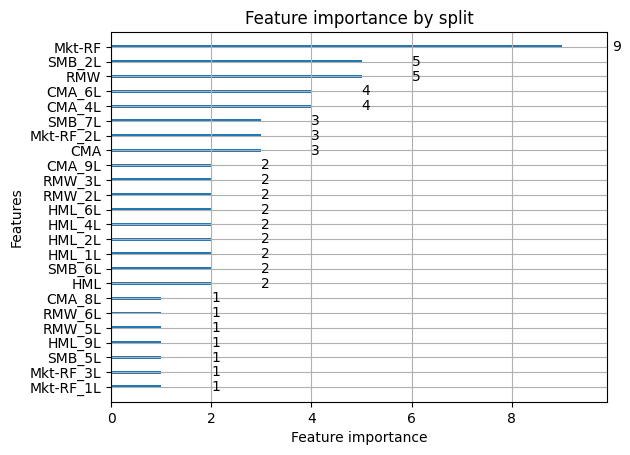

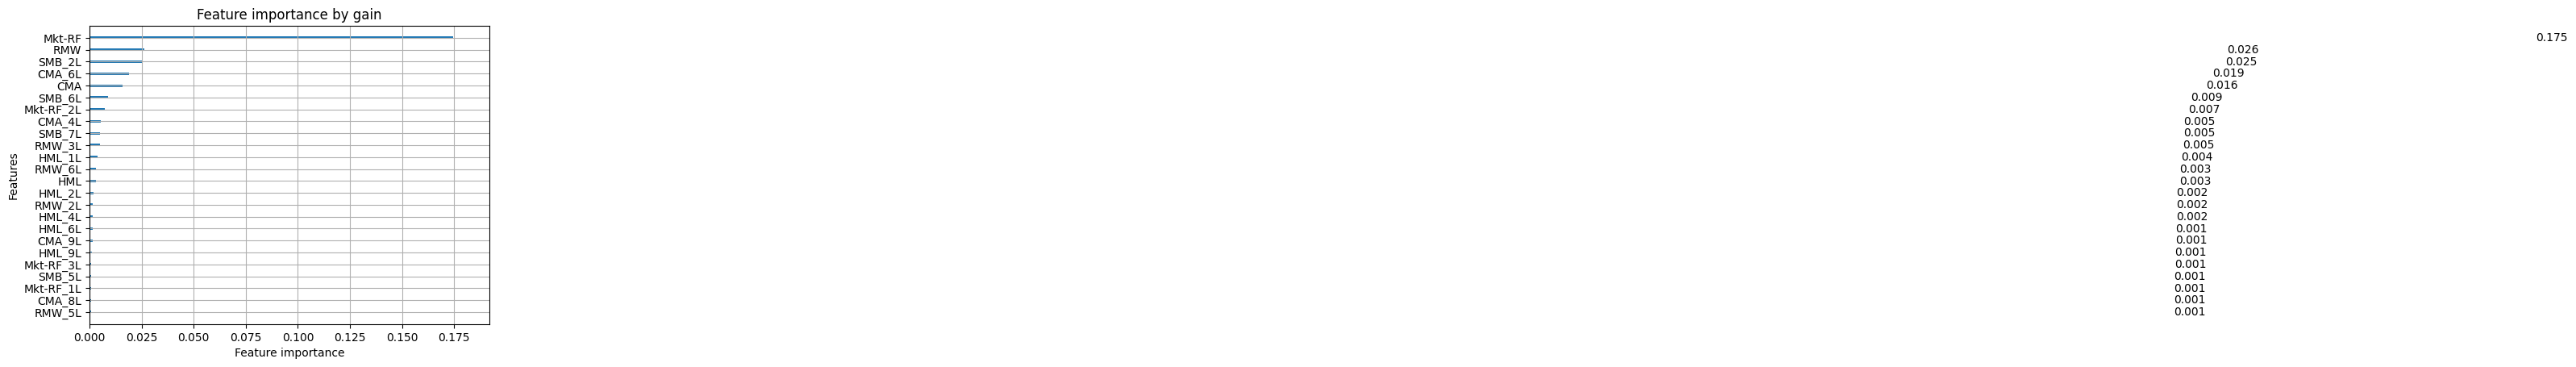

In [29]:
# fig = plt.plot(figsize=(15, 20))

top25 = 25

plot_importance(
    model_gbm,
    importance_type='split',
    max_num_features=min(top25, len(X.columns)),
    title="Feature importance by split",
)

plot_importance(
    model_gbm,
    importance_type='gain',
    max_num_features=min(top25, len(X.columns)),
    title="Feature importance by gain",
)

plt.show()

In [30]:
top15features_indexes = model_gbm.feature_importances_.argsort()[-15:]
top15features_stable = list(pd.Series(selected_features)[
                            top15features_indexes].values)

In [31]:
top15features_stable

['RMW_2L',
 'HML_6L',
 'HML_4L',
 'HML_1L',
 'SMB_6L',
 'HML',
 'RMW_3L',
 'SMB_7L',
 'Mkt-RF_2L',
 'CMA',
 'CMA_4L',
 'CMA_6L',
 'SMB_2L',
 'RMW',
 'Mkt-RF']

### Исследуем feature importance на случайной подвыборке из акций